# Time series forecasting

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single timestep:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [1]:
import os
import io
import datetime
import asyncio

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import yfinance as yf
import pytz
import aiofiles
import zipfile
from ta import add_all_ta_features

mpl.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams['axes.grid'] = False

## FirstRate Data complete us stocks index etf futures bundle

Purchased this bundle from FirstRate Data.

https://firstratedata.com/cb/1/complete-us-stocks-index-etf-futures

`Date, Time, Open, High, Low, Close, Volume`

This analysis will just deal with **1min predictions**.

In [2]:
data_path = 'data/input/firstratedata/most-liquid-us-stocks-1500'

In [3]:
assert os.path.isdir(data_path)

In [4]:
tickers = ['tsla']

In [5]:
columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

In [6]:
def firstratedata_df(text_io, columns):
    df = pd.read_csv(text_io, names=columns, index_col=None)
    df['datetime'] = df['datetime'].apply(pd.Timestamp)
    df = df.set_index(['datetime'])
    return df
#     return df.drop(['date', 'time'], axis=1)

In [7]:
async def async_read_df(path, columns):
    async with aiofiles.open(path) as aiofile:
        contents = await aiofile.read()
        with io.StringIO(contents) as text_io:
            return firstratedata_df(text_io, columns)

In [8]:
paths = [f'{data_path}/{path}' for path in os.listdir(data_path) if all(ignore not in path for ignore in ['readme', 'index']) and path.endswith('.zip')]

In [9]:
paths

['data/input/firstratedata/most-liquid-us-stocks-1500/us_1500_2020_all_tickers_hgj7gj.zip',
 'data/input/firstratedata/most-liquid-us-stocks-1500/us_1500_tickers_D_F_hgj7gj.zip',
 'data/input/firstratedata/most-liquid-us-stocks-1500/us_1500_tickers_A_C_hgj7gj.zip',
 'data/input/firstratedata/most-liquid-us-stocks-1500/us_1500_tickers_T_Z_hgj7gj.zip',
 'data/input/firstratedata/most-liquid-us-stocks-1500/us_1500_tickers_G_L_hgj7gj.zip',
 'data/input/firstratedata/most-liquid-us-stocks-1500/us_1500_tickers_M_N_hgj7gj.zip',
 'data/input/firstratedata/most-liquid-us-stocks-1500/us_1500_tickers_O_S_hgj7gj.zip']

In [10]:
# def unzipped_paths(path):
#     extract_path = path.split('.')[0]
#     with zipfile.ZipFile(path, "r") as zip_ref:
#         zip_ref.extractall(extract_path)
#     return [f'{path}/{sub_path}' for sub_path in os.listdir(extract_path)]
    

In [11]:
# xs = [sub_path for p in paths for sub_path in unzipped_paths(p)]

In [12]:
tsla_pre_2020_path = f'{data_path}/us_1500_tickers_T_Z_hgj7gj/TSLA_2010_2019.txt'

In [13]:
tsla_2020_path = f'{data_path}/us_1500_2020_all_tickers_hgj7gj/TSLA_2020_2020.txt'

In [14]:
tsla_pre_2020_df = await async_read_df(tsla_pre_2020_path, columns)

In [15]:
tsla_pre_2020_df.head()


,open,high,low,close,volume
datetime,,,,,
2010-06-29 11:25:00,3.80,3.80,3.71,3.71,12294795
2010-06-29 11:26:00,3.71,3.79,3.67,3.67,2374395
2010-06-29 11:27:00,3.68,3.80,3.61,3.62,3290105
2010-06-29 11:28:00,3.62,3.65,3.61,3.65,2292765
2010-06-29 11:29:00,3.64,3.80,3.64,3.64,1924935


In [16]:
tsla_2020_df = await async_read_df(tsla_2020_path, columns)

In [17]:
tsla_2020_df.head()

,open,high,low,close,volume
datetime,,,,,
2020-01-02 04:00:00,84.18,84.20,84.18,84.20,6585
2020-01-02 04:03:00,84.41,84.50,84.41,84.50,4640
2020-01-02 04:04:00,84.43,84.43,84.43,84.43,1780
2020-01-02 04:07:00,84.60,84.60,84.60,84.60,1005
2020-01-02 04:14:00,84.51,84.51,84.51,84.51,800


In [18]:
tsla_df = pd.concat([tsla_pre_2020_df, tsla_2020_df], axis=0, join='outer')

In [19]:
tsla_df.head()

,open,high,low,close,volume
datetime,,,,,
2010-06-29 11:25:00,3.80,3.80,3.71,3.71,12294795
2010-06-29 11:26:00,3.71,3.79,3.67,3.67,2374395
2010-06-29 11:27:00,3.68,3.80,3.61,3.62,3290105
2010-06-29 11:28:00,3.62,3.65,3.61,3.65,2292765
2010-06-29 11:29:00,3.64,3.80,3.64,3.64,1924935


In [20]:
tsla_df.tail()

,open,high,low,close,volume
datetime,,,,,
2021-01-08 19:55:00,867.00,867.25,866.98,867.25,11879
2021-01-08 19:56:00,867.25,867.95,867.25,867.62,9749
2021-01-08 19:57:00,867.50,868.00,867.30,867.67,8723
2021-01-08 19:58:00,867.75,867.75,867.25,867.60,6599
2021-01-08 19:59:00,867.50,867.60,867.25,867.50,13250


array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>], dtype=object)

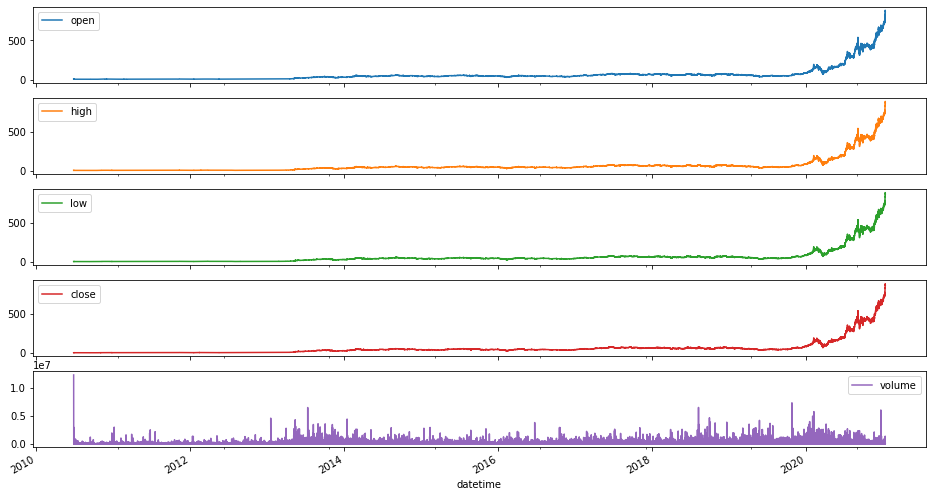

In [21]:
tsla_df.plot(subplots=True)

In [22]:
tsla_df.head()

,open,high,low,close,volume
datetime,,,,,
2010-06-29 11:25:00,3.80,3.80,3.71,3.71,12294795
2010-06-29 11:26:00,3.71,3.79,3.67,3.67,2374395
2010-06-29 11:27:00,3.68,3.80,3.61,3.62,3290105
2010-06-29 11:28:00,3.62,3.65,3.61,3.65,2292765
2010-06-29 11:29:00,3.64,3.80,3.64,3.64,1924935


In [23]:
tsla_df.tail()

,open,high,low,close,volume
datetime,,,,,
2021-01-08 19:55:00,867.00,867.25,866.98,867.25,11879
2021-01-08 19:56:00,867.25,867.95,867.25,867.62,9749
2021-01-08 19:57:00,867.50,868.00,867.30,867.67,8723
2021-01-08 19:58:00,867.75,867.75,867.25,867.60,6599
2021-01-08 19:59:00,867.50,867.60,867.25,867.50,13250


In [58]:
df = dropna(tsla_df)

In [24]:
df = tsla_df.copy()

### Inspect and cleanup

Next look at the statistics of the dataset:

In [25]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open,1328667.0,78.548230,119.452818,3.01,30.40,47.08,65.10,8.839650e+02
high,1328667.0,78.610580,119.556527,3.01,30.42,47.11,65.14,8.848900e+02
low,1328667.0,78.485977,119.350015,3.00,30.36,47.05,65.06,8.826800e+02
close,1328667.0,78.547996,119.453256,3.01,30.40,47.08,65.10,8.839900e+02
volume,1328667.0,62484.828665,113820.364415,0.00,5465.00,25490.00,73450.00,1.229480e+07


In [26]:
df.dtypes

open      float64
high      float64
low       float64
close     float64
volume      int64
dtype: object

In [27]:
assert not df.isna().any(axis=0).any()

### Feature engineering

Before diving in to build a model it's important to understand your data, and be sure that you're passing the model appropriately formatted data.

#### Time

We want to account for seasonality in prices. We can map our `date` index feature datetimes into useable signals using sin and cos.

In [28]:
index_timestamp_seconds = np.array(df.index.map(datetime.datetime.timestamp))
index_timestamp_seconds[:5]

array([1.27782510e+09, 1.27782516e+09, 1.27782522e+09, 1.27782528e+09,
       1.27782534e+09])

In [29]:
seconds_per_day = 24 * 60 * 60
seconds_per_year = 365.2425 * seconds_per_day
date_to_year_sin = np.sin(index_timestamp_seconds * (2 * np.pi / seconds_per_year))
date_to_year_cos = np.cos(index_timestamp_seconds * (2 * np.pi / seconds_per_year))

Text(0.5, 1.0, 'Time of year signal')

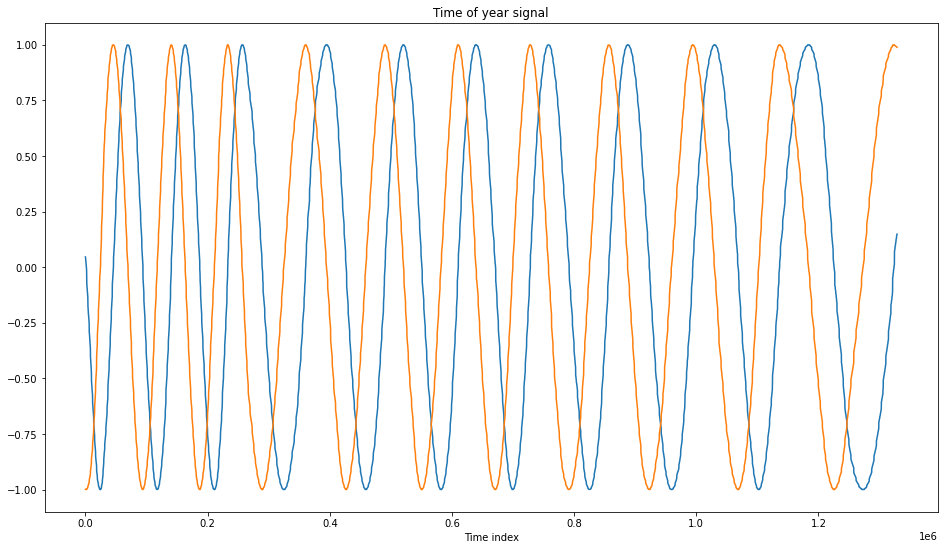

In [30]:
plt.plot(np.array(date_to_year_sin))
plt.plot(np.array(date_to_year_cos))
plt.xlabel('Time index')
plt.title('Time of year signal')

array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>], dtype=object)

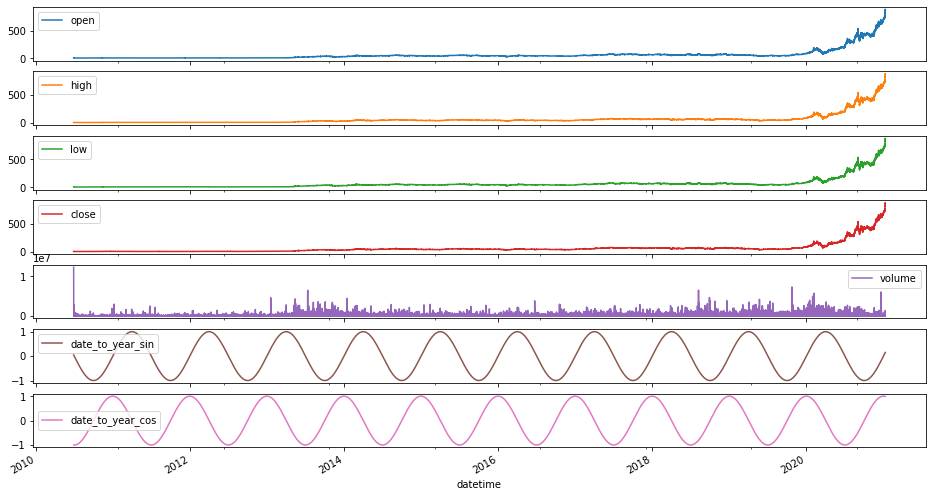

In [31]:
df['date_to_year_sin'] = date_to_year_sin
df['date_to_year_cos'] = date_to_year_cos
df.plot(subplots=True)

#### Indicators

nasdaq trading hours are 04:00 - 20:00 eastern standard time.

In [32]:
NASDAQ_TRADING_HOURS_PER_DAY = 16 

In [33]:
TICKS_PER_DAY = 60 * NASDAQ_TRADING_HOURS_PER_DAY

In [34]:
INDICATOR_DAYS = 7

In [35]:
indicator_ticks = TICKS_PER_DAY * INDICATOR_DAYS

In [36]:
# Add all ta features
df = add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

/Users/alexanderlerma/go/src/github.com/neuralnetes/notebooks/time-series/.venv/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/alexanderlerma/go/src/github.com/neuralnetes/notebooks/time-series/.venv/lib/python3.7/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [37]:
df.head()

,open,high,low,close,volume,date_to_year_sin,date_to_year_cos,volume_adi,volume_obv,volume_cmf,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
datetime,,,,,,,,,,,,,,,,,,,,,
2010-06-29 11:25:00,3.80,3.80,3.71,3.71,12294795,0.046068,-0.998938,-1.229480e+07,12294795,-1.000000,...,-100.000000,0.0,3.710000,0.0,0.000000,0.000000,0.000000,-95.276773,0.000000,0.000000
2010-06-29 11:26:00,3.71,3.79,3.67,3.67,2374395,0.046056,-0.998939,-1.466919e+07,9920400,-1.000000,...,-100.000000,0.0,3.692241,0.0,-6.845799,-1.369160,-5.476639,-1.078167,-1.084021,-1.078167
2010-06-29 11:27:00,3.68,3.80,3.61,3.62,3290105,0.046044,-0.998939,-1.761297e+07,6630295,-0.980716,...,-94.736842,0.0,3.660183,0.0,-12.142866,-3.523901,-8.618965,-1.362398,-1.371764,-2.425876
2010-06-29 11:28:00,3.62,3.65,3.61,3.65,2292765,0.046032,-0.998940,-1.532020e+07,8923060,-0.756476,...,-78.947368,0.0,3.655660,0.0,-17.612634,-6.341647,-11.270986,0.828729,0.825314,-1.617251
2010-06-29 11:29:00,3.64,3.80,3.64,3.64,1924935,0.046020,-0.998941,-1.724514e+07,6998125,-0.777614,...,-84.210526,0.0,3.648708,0.0,-22.761405,-9.625599,-13.135806,-0.273973,-0.274349,-1.886792


In [38]:
df.tail()

,open,high,low,close,volume,date_to_year_sin,date_to_year_cos,volume_adi,volume_obv,volume_cmf,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-08 19:55:00,867.00,867.25,866.98,867.25,11879,0.148608,0.988896,7.626725e+08,7661795979,-0.049982,...,-66.843147,-0.684994,867.683144,-0.059924,22.127554,-0.078243,22.205797,0.028835,0.028831,23276.010782
2021-01-08 19:56:00,867.25,867.95,867.25,867.62,9749,0.148619,0.988894,7.626731e+08,7661805728,-0.071513,...,-47.055992,-0.649141,867.682073,-0.047233,27.772248,5.491855,22.280393,0.042664,0.042654,23285.983827
2021-01-08 19:57:00,867.50,868.00,867.30,867.67,8723,0.148631,0.988893,7.626736e+08,7661814451,-0.005232,...,-44.382053,-0.489347,867.682013,-0.038030,29.480315,10.289547,19.190768,0.005763,0.005763,23287.331536
2021-01-08 19:58:00,867.75,867.75,867.25,867.60,6599,0.148643,0.988891,7.626762e+08,7661807852,0.017657,...,-48.125568,-0.415376,867.679409,-0.046083,27.489082,13.729454,13.759628,-0.008068,-0.008068,23285.444744
2021-01-08 19:59:00,867.50,867.60,867.25,867.50,13250,0.148655,0.988889,7.626819e+08,7661794602,0.045447,...,-52.197802,-0.367876,867.677234,-0.023049,33.093609,17.602285,15.491324,-0.011526,-0.011527,23282.749326


In [55]:
df = dropna(df)

In [39]:
df.head()

,open,high,low,close,volume,date_to_year_sin,date_to_year_cos,volume_adi,volume_obv,volume_cmf,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
datetime,,,,,,,,,,,,,,,,,,,,,
2010-06-29 11:25:00,3.80,3.80,3.71,3.71,12294795,0.046068,-0.998938,-1.229480e+07,12294795,-1.000000,...,-100.000000,0.0,3.710000,0.0,0.000000,0.000000,0.000000,-95.276773,0.000000,0.000000
2010-06-29 11:26:00,3.71,3.79,3.67,3.67,2374395,0.046056,-0.998939,-1.466919e+07,9920400,-1.000000,...,-100.000000,0.0,3.692241,0.0,-6.845799,-1.369160,-5.476639,-1.078167,-1.084021,-1.078167
2010-06-29 11:27:00,3.68,3.80,3.61,3.62,3290105,0.046044,-0.998939,-1.761297e+07,6630295,-0.980716,...,-94.736842,0.0,3.660183,0.0,-12.142866,-3.523901,-8.618965,-1.362398,-1.371764,-2.425876
2010-06-29 11:28:00,3.62,3.65,3.61,3.65,2292765,0.046032,-0.998940,-1.532020e+07,8923060,-0.756476,...,-78.947368,0.0,3.655660,0.0,-17.612634,-6.341647,-11.270986,0.828729,0.825314,-1.617251
2010-06-29 11:29:00,3.64,3.80,3.64,3.64,1924935,0.046020,-0.998941,-1.724514e+07,6998125,-0.777614,...,-84.210526,0.0,3.648708,0.0,-22.761405,-9.625599,-13.135806,-0.273973,-0.274349,-1.886792


In [191]:
df = df.dropna(axis=0)

In [40]:
output_path = f'{data_path}/tsla-with-indicators.csv'

In [41]:
df.to_csv(output_path)

### Split the data

We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [42]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [43]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors.

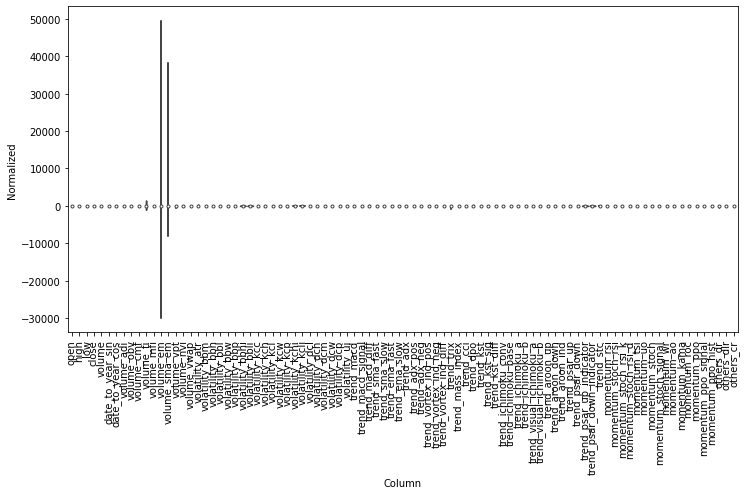

In [44]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [73]:
df.isna().any(axis=0).any()

False

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24h into the future, given 24h of history you might define a window like this:

  ![One prediction 24h into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction 1h into the future, given 6h of history would need a window like this:

  ![One prediction 1h into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into a `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to `tf.data.Dataset`s of windows later.

In [74]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [75]:
label_columns = ['close']

In [76]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=label_columns)
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['close']

In [77]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=label_columns)
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['close']

### 2. Split
Given a list consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2`, above, will be split like this:

![The initial window is all consecuitive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [78]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [79]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 90)
Inputs shape: (3, 6, 90)
labels shape: (3, 1, 1)


Typically data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of 3, 7-timestep windows, with 19 features at each time step. It split them into a batch of 6-timestep, 19 feature inputs, and a 1-timestep 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['tsla_close']`. Initially this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [80]:
w2.example = example_inputs, example_labels

In [81]:
def plot(self, model=None, plot_col='close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [1m]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

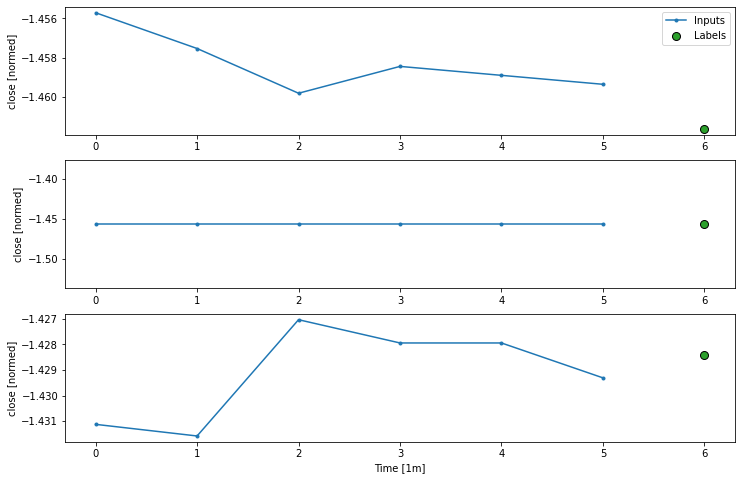

In [82]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `tsla_close` column.

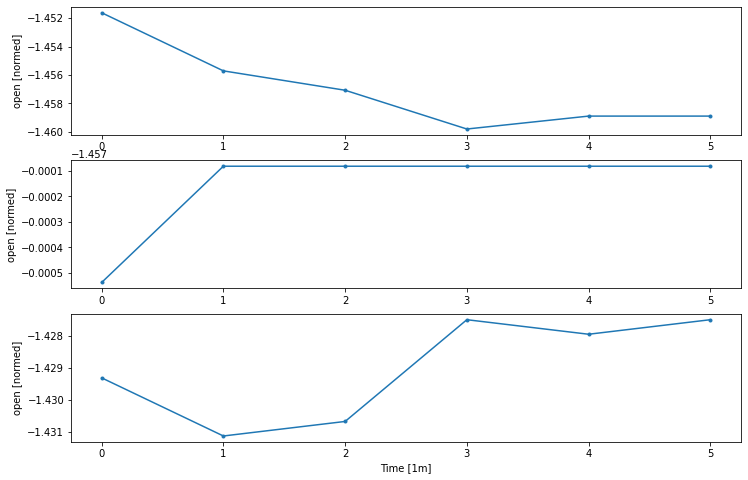

In [83]:
w2.plot(plot_col='open')

### 4. Create `tf.data.Dataset`s

Finally this `make_dataset` method will take a time series `DataFrame` and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `preprocessing.timeseries_dataset_from_array` function.

In [84]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation and test data. Add properties for accessing them as `tf.data.Datasets` using the above `make_dataset` method. Also add a standard example batch for easy access and plotting:

In [88]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, `dtypes` and shapes of the dataset elements.

In [89]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 90), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [90]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 90)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value, 1 timestep (1h) in the future based only on the current conditions.

So start by building models to predict the `tsla_close` value 1h into the future.

![Predict the next time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [91]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=label_columns)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['close']

The `window` object creates `tf.data.Datasets` from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [92]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 90)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature 1h in the future given the current value of all features. The current values include the current temperature. 

So start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [93]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [94]:
baseline = Baseline(label_index=column_indices['close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

8305/8305 [==============================] - 8s 899us/step - loss: 6.2926e-05 - mean_absolute_error: 0.0037


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample. So, create a wider `WindowGenerator` that generates windows 24h of consecutive inputs and labels at a time. 

The `wide_window` doesn't change the way the model operates. The model still makes predictions 1h into the future based on a single input time step. Here the `time` axis acts like the `batch` axis: Each prediction is made independently with no interaction between time steps.

In [95]:
wide_window = WindowGenerator(
    input_width=TICKS_PER_DAY, label_width=TICKS_PER_DAY, shift=1,
    label_columns=label_columns)

wide_window

Total window size: 961
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of timesteps, and the baseline just forwards the input to the output:

  ![One prediction 1h into the future, ever hour.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)

In [96]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 960, 90)
Output shape: (32, 960, 1)


Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 30m.

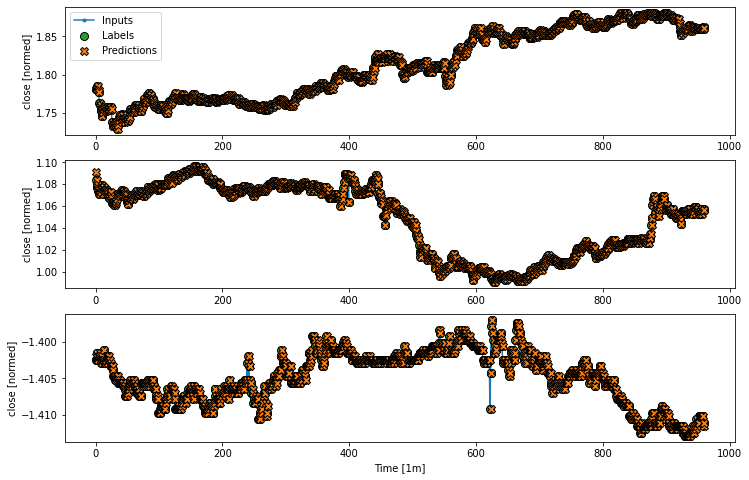

In [97]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24h. This deserves some explaination:

* The blue "Inputs" line shows the input tsla_close at each time step. The model recieves all features, this plot only shows the tsla_close.
* The green "Labels" dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
* The orange "Predictions" crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the "labels".

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

A `layers.Dense` with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`, it is applied independently to every item across the `batch` and `time` axes.

In [98]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [99]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 90)
Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [100]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

Epoch 1/20
29065/29065 [==============================] - 37s 1ms/step - loss: 0.0855 - mean_absolute_error: 0.0654 - val_loss: 4.7289e-04 - val_mean_absolute_error: 0.0100
Epoch 2/20
29065/29065 [==============================] - 37s 1ms/step - loss: 0.0222 - mean_absolute_error: 0.0128 - val_loss: 4.0324e-04 - val_mean_absolute_error: 0.0101
Epoch 3/20
29065/29065 [==============================] - 37s 1ms/step - loss: 0.0176 - mean_absolute_error: 0.0136 - val_loss: 3.7297e-04 - val_mean_absolute_error: 0.0094
Epoch 4/20
29065/29065 [==============================] - 37s 1ms/step - loss: 0.0161 - mean_absolute_error: 0.0137 - val_loss: 5.9511e-04 - val_mean_absolute_error: 0.0139
Epoch 5/20
8305/8305 [==============================] - 8s 927us/step - loss: 5.2065e-04 - mean_absolute_error: 0.0108


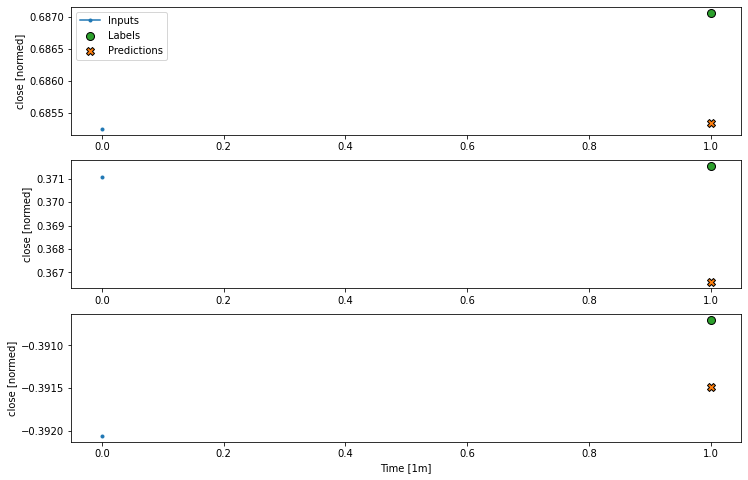

In [101]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)
single_step_window.plot(linear)

Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecuitive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_window.png?raw=1)

In [102]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 960, 90)
Output shape: (32, 960, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input `tsla_close`, but in a few cases it's worse:

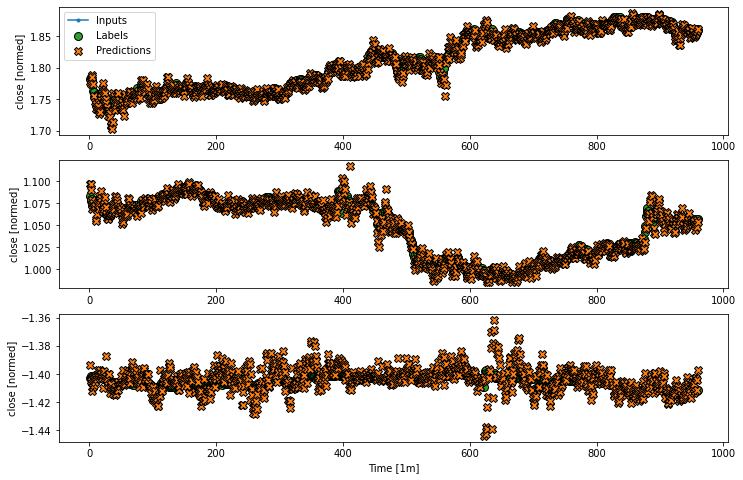

In [103]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights, and see the weight assigned to each input:

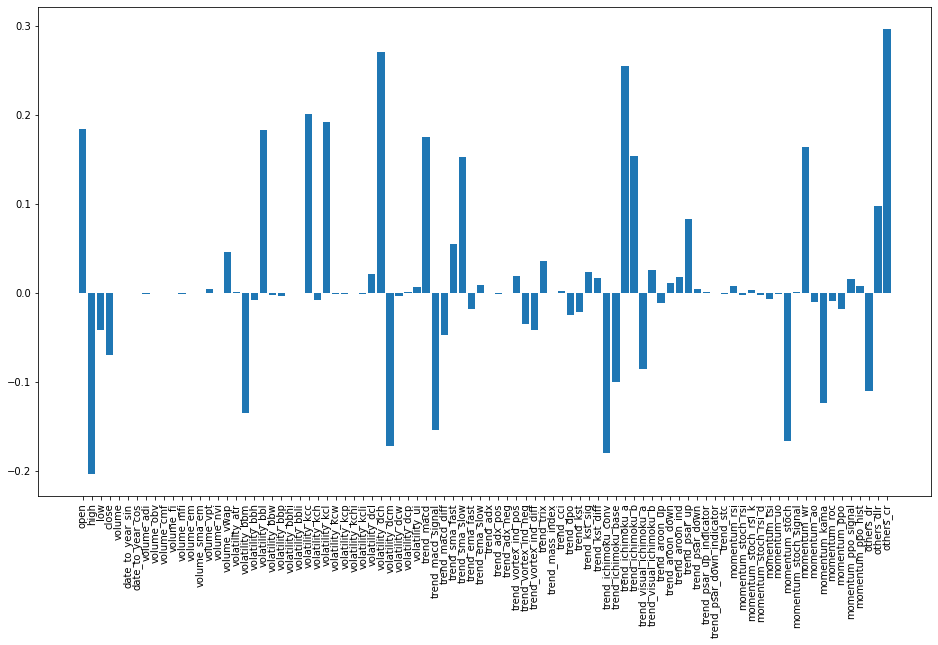

In [104]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `tsla_close`. This is one of the risks of random initialization. 

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [105]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
29065/29065 [==============================] - 41s 1ms/step - loss: 0.0257 - mean_absolute_error: 0.0372 - val_loss: 0.0040 - val_mean_absolute_error: 0.0206
Epoch 2/20
29065/29065 [==============================] - 40s 1ms/step - loss: 0.0010 - mean_absolute_error: 0.0068 - val_loss: 2.5601e-04 - val_mean_absolute_error: 0.0064
Epoch 3/20
29065/29065 [==============================] - 40s 1ms/step - loss: 7.2015e-05 - mean_absolute_error: 0.0035 - val_loss: 2.4507e-04 - val_mean_absolute_error: 0.0097
Epoch 4/20
29065/29065 [==============================] - 40s 1ms/step - loss: 6.8142e-05 - mean_absolute_error: 0.0031 - val_loss: 1.4525e-04 - val_mean_absolute_error: 0.0058
Epoch 5/20
29065/29065 [==============================] - 40s 1ms/step - loss: 4.1302e-05 - mean_absolute_error: 0.0029 - val_loss: 1.1830e-04 - val_mean_absolute_error: 0.0053
Epoch 6/20
29065/29065 [==============================] - 40s 1ms/step - loss: 4.0316e-05 - mean_absolute_error: 0.0029 - val_l

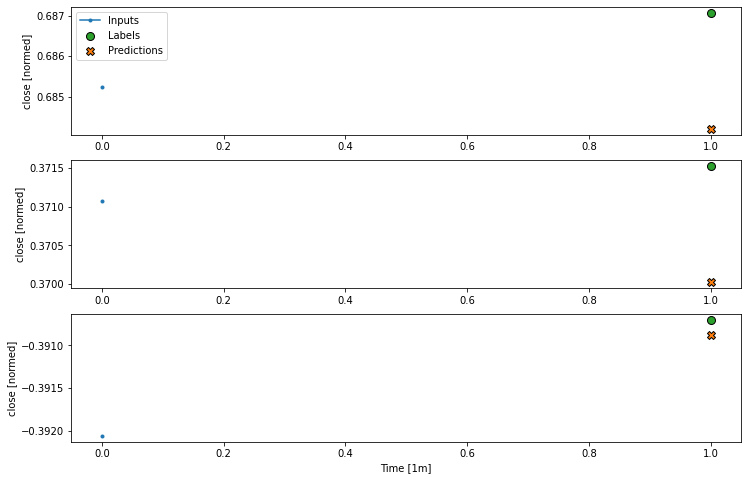

In [106]:
single_step_window.plot(dense)

### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of the 3h of inputs and, 1h of labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [107]:
CONV_WIDTH = TICKS_PER_DAY // 32
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['close'])

conv_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['close']

Text(0.5, 1.0, 'Given 30 1 min ticks as input, predict 1 1 min tick into the future.')

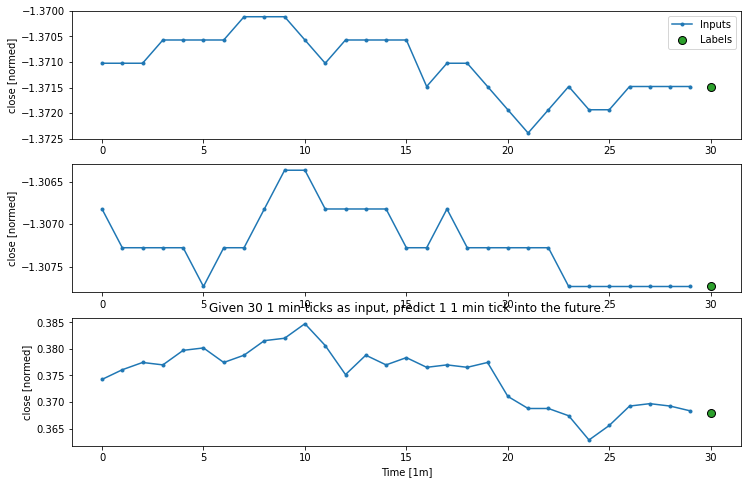

In [108]:
conv_window.plot()
plt.title(f"Given {CONV_WIDTH} 1 min ticks as input, predict 1 1 min tick into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `layers.Flatten` as the first layer of the model:

In [109]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [110]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 30, 90)
Output shape: (32, 1, 1)


In [111]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

8304/8304 [==============================] - 9s 1ms/step - loss: 4.9250e-04 - mean_absolute_error: 0.0141


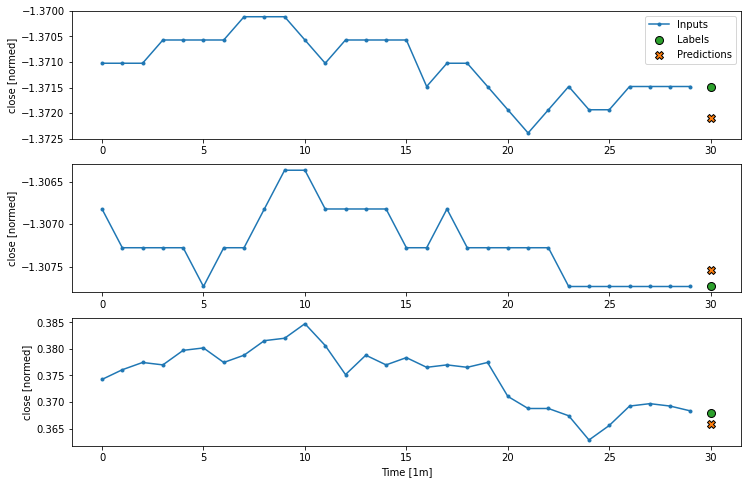

In [112]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 

In [113]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 960, 90)

ValueError:Input 0 of layer dense_4 is incompatible with the layer: expected axis -1 of input shape to have value 2700 but received input with shape (32, 86400)


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `layers.Flatten` and the first `layers.Dense` are replaced by a `layers.Conv1D`.
* The `layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [114]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to see that the model produces outputs with the expected shape:

In [115]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 30, 90)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

8304/8304 [==============================] - 10s 1ms/step - loss: 3.1851e-04 - mean_absolute_error: 0.0110


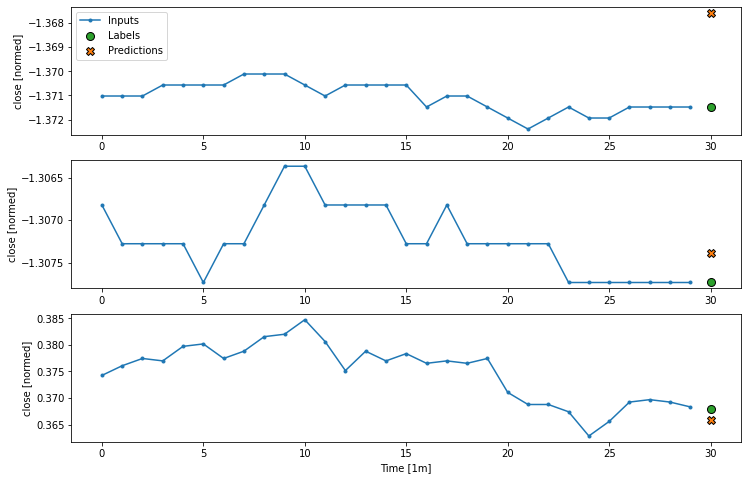

In [116]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)
conv_window.plot(conv_model)

The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_conv_window.png?raw=1)

If you run it on wider input, it produces wider output:

In [117]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 960, 90)
Labels shape: (32, 960, 1)
Output shape: (32, 931, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [118]:
LABEL_WIDTH = TICKS_PER_DAY * 1
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['close'])

wide_conv_window

Total window size: 990
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [119]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 989, 90)
Labels shape: (32, 960, 1)
Output shape: (32, 960, 1)


Now you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding timesteps:

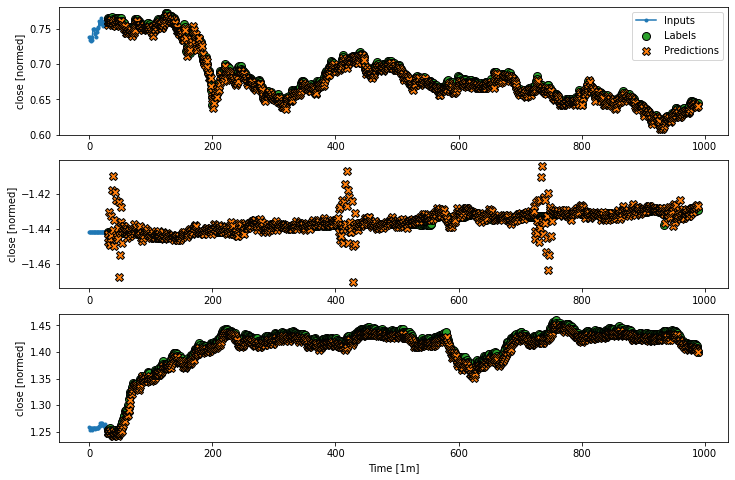

In [120]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

For more details, read the [text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation) or the [RNN guide](https://www.tensorflow.org/guide/keras/rnn). 

In this tutorial, you will use an RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)).

An important constructor argument for all keras RNN layers is the `return_sequences` argument. This setting can configure the layer in one of two ways.

1. If `False`, the default, the layer only returns the output of the final timestep, giving the model time to warm up its internal state before making a single prediction: 

![An lstm warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. If `True` the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple timesteps simultaneously.

![An lstm making a prediction after every timestep](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True` the model can be trained on a full days worth of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first timestep the model has no access to previous steps, and so can't do any better than the simple `linear` and `dense` models shown earlier.

In [122]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 960, 90)
Output shape: (32, 960, 1)


In [123]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
wide_window.plot(lstm_model)

Epoch 1/20
29035/29035 [==============================] - 5013s 173ms/step - loss: 0.0080 - mean_absolute_error: 0.0194 - val_loss: 0.6911 - val_mean_absolute_error: 0.3038
Epoch 2/20
29035/29035 [==============================] - 16977s 585ms/step - loss: 1.0905e-05 - mean_absolute_error: 0.0021 - val_loss: 0.6021 - val_mean_absolute_error: 0.2764
Epoch 3/20
29035/29035 [==============================] - 16726s 576ms/step - loss: 9.5747e-06 - mean_absolute_error: 0.0019 - val_loss: 0.6425 - val_mean_absolute_error: 0.2908
Epoch 4/20
14451/29035 [=============>................] - ETA: 41:43 - loss: 8.5487e-06 - mean_absolute_error: 0.0018

KeyboardInterrupt: 

Taking too long, containerizing this workflow and moving into kubeflow.

Everything below this is based on kibot 30min dataset.

### Performance

With this dataset typically each of the models does slightly better than the one before it.

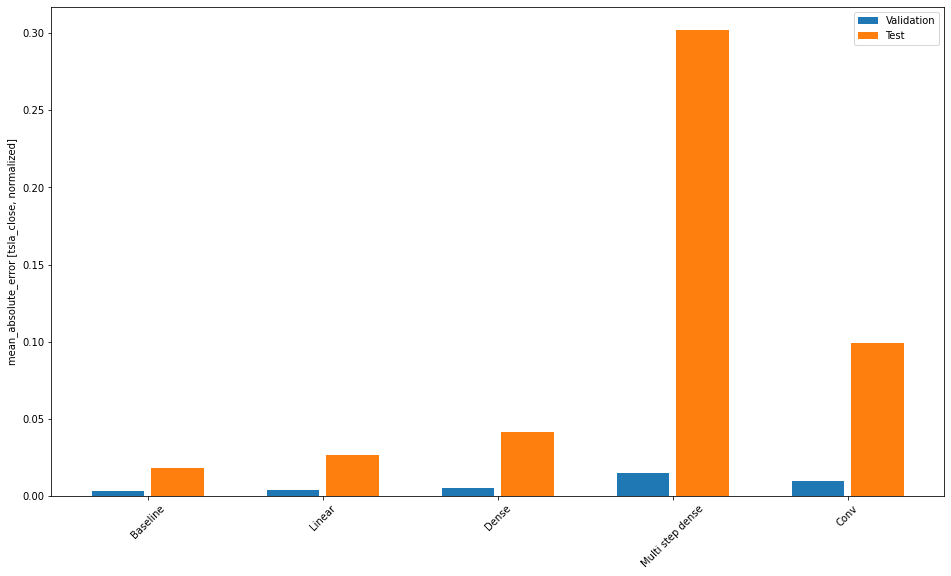

In [250]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [tsla_close, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [252]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0184
Linear      : 0.0265
Dense       : 0.0414
Multi step dense: 0.3017
Conv        : 0.0994


### Multi-output models

The models so far all predicted a single output feature, `close`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels`.


In [254]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=TICKS_PER_DAY, label_width=TICKS_PER_DAY, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 960, 12)
Labels shape (batch, time, features): (32, 960, 12)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of 1.

#### Baseline

The same baseline model can be used here, but this time repeating all features instead of selecting a specific `label_index`.

In [255]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

8233/8233 [==============================] - 30s 4ms/step - loss: 0.1272 - mean_absolute_error: 0.0436


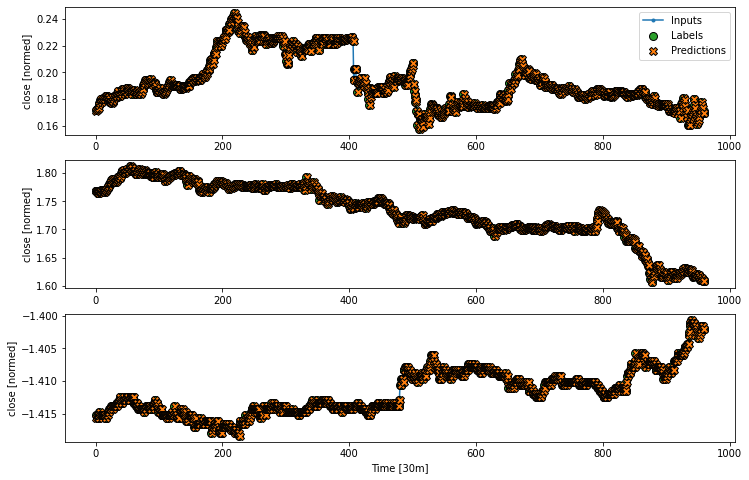

In [256]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)
wide_window.plot(baseline)

#### Dense

In [257]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

8263/8263 [==============================] - 8s 1ms/step - loss: 0.1244 - mean_absolute_error: 0.0758


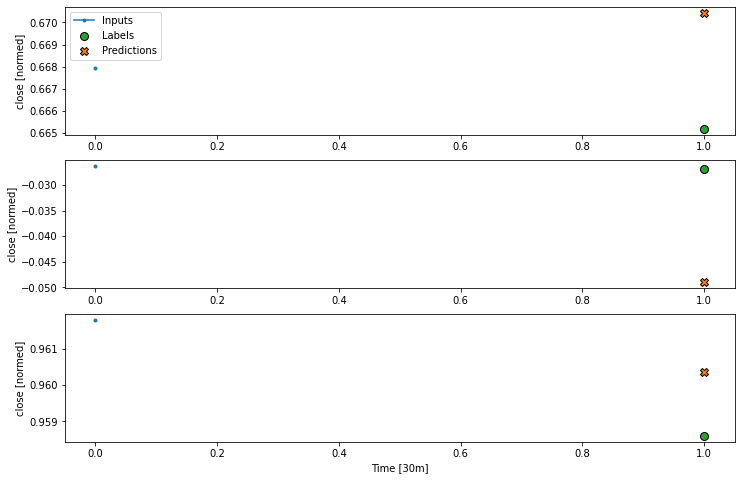

In [258]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)
single_step_window.plot(dense)

#### RNN


In [259]:
%%time
wide_window = WindowGenerator(
    input_width=TICKS_PER_DAY, label_width=TICKS_PER_DAY, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
wide_window.plot(lstm_model)

Epoch 1/20
   90/28888 [..............................] - ETA: 1:13:14 - loss: 0.6275 - mean_absolute_error: 0.5962

KeyboardInterrupt: 

<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next timestep.
Similarly, "Residual networks" or "ResNets" in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/residual.png?raw=1)

Essentially this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [260]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [261]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
wide_window.plot(residual_lstm)

Epoch 1/20
   20/28888 [..............................] - ETA: 1:13:41 - loss: 0.0527 - mean_absolute_error: 0.0293

KeyboardInterrupt: 

#### Performance

Here is the overall performance for these multi-output models.

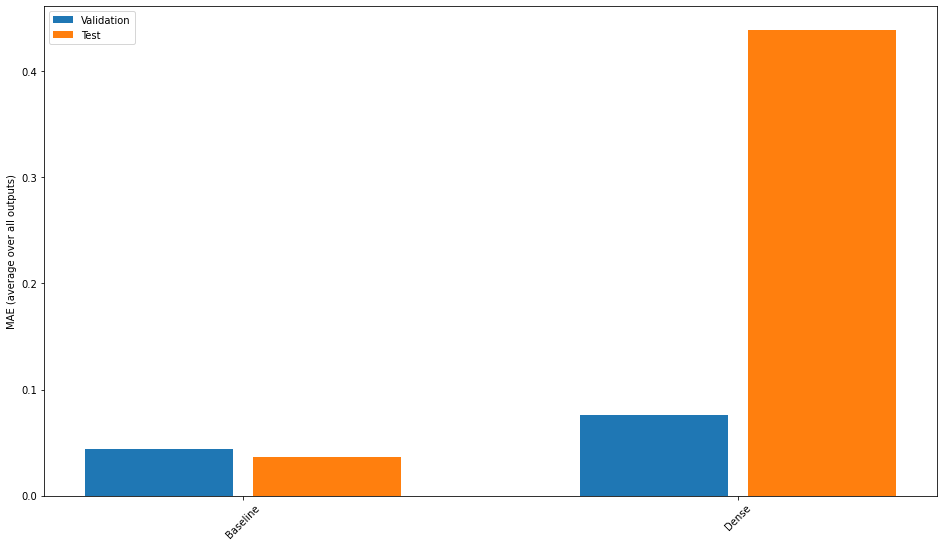

In [262]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [263]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.0368
Dense          : 0.4393


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, 1h into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24h of the future, given 24h of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 1920
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236

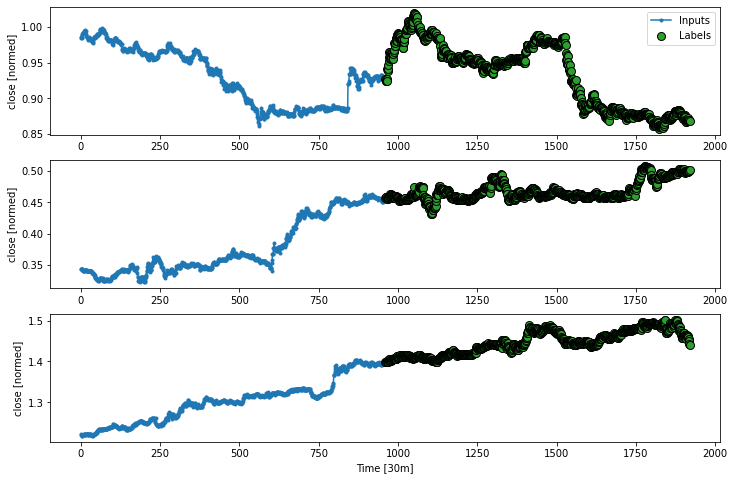

In [264]:
OUT_STEPS = TICKS_PER_DAY
multi_window = WindowGenerator(input_width=OUT_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output timesteps:

![Repeat the last input, for each output step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_last.png?raw=1)

8203/8203 [==============================] - 28s 3ms/step - loss: 0.4803 - mean_absolute_error: 0.1773


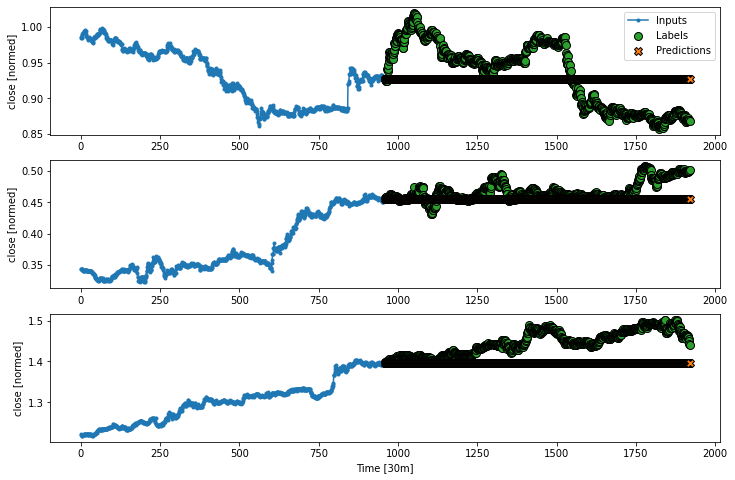

In [265]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Since this task is to predict 24h given 24h another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_repeat.png?raw=1)

8203/8203 [==============================] - 27s 3ms/step - loss: 0.5391 - mean_absolute_error: 0.2311


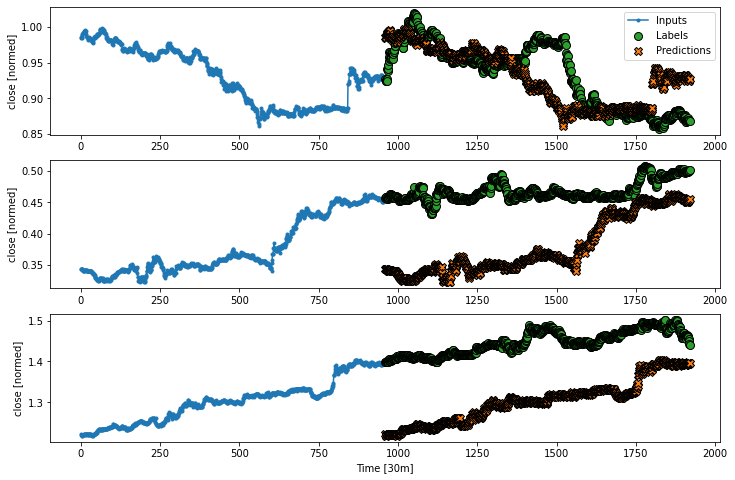

In [266]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

One high level approach to this problem is use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predct all timesteps from the last time-step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_dense.png?raw=1)

8203/8203 [==============================] - 36s 4ms/step - loss: 0.2957 - mean_absolute_error: 0.1548


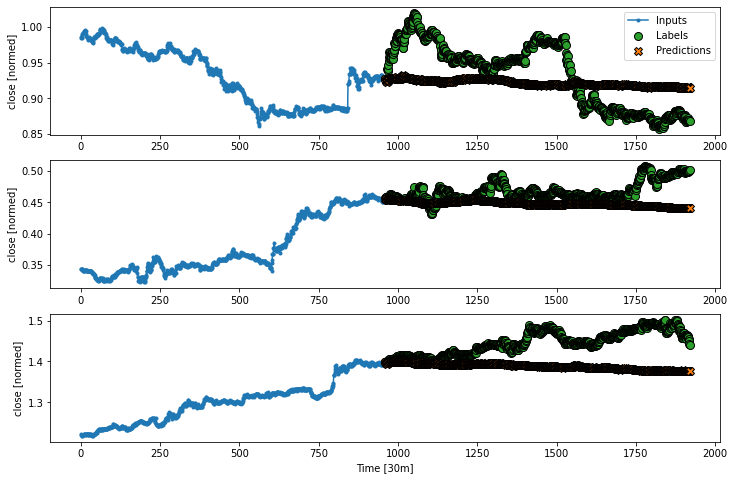

In [267]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input timestep.

430/430 [==============================] - 1s 1ms/step - loss: 0.2205 - mean_absolute_error: 0.1458


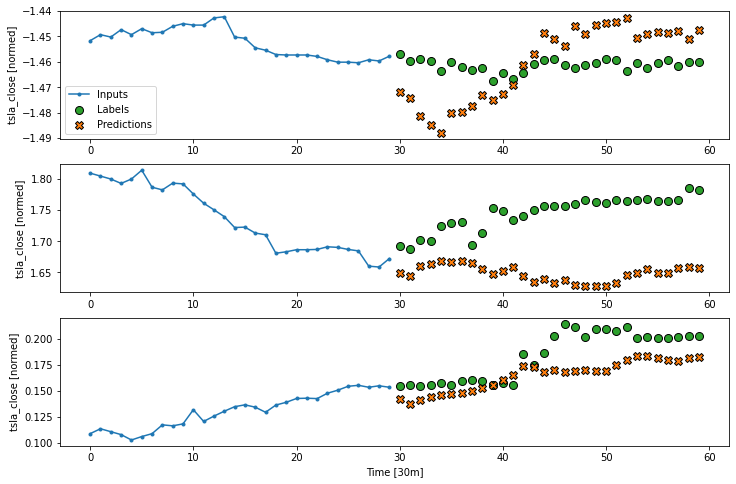

In [454]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_conv.png?raw=1)

430/430 [==============================] - 1s 1ms/step - loss: 0.1975 - mean_absolute_error: 0.1443


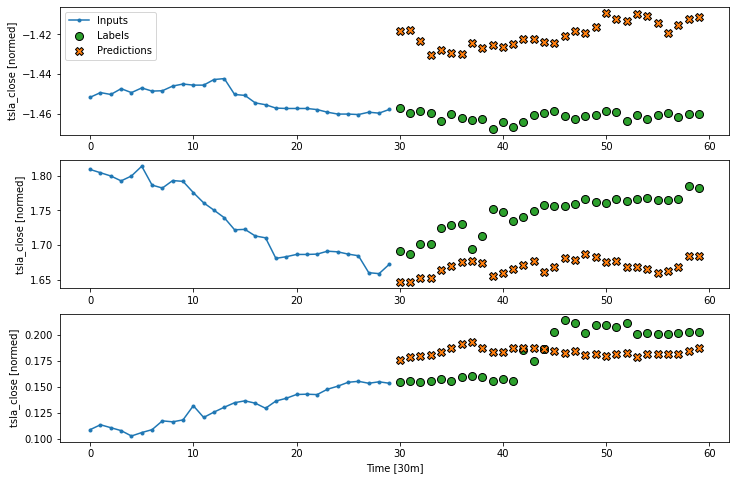

In [455]:
CONV_WIDTH = TICKS_PER_DAY // 4
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24h, before making a single prediction for the next 24h.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False`.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_lstm.png?raw=1)


430/430 [==============================] - 1s 2ms/step - loss: 0.5069 - mean_absolute_error: 0.2513


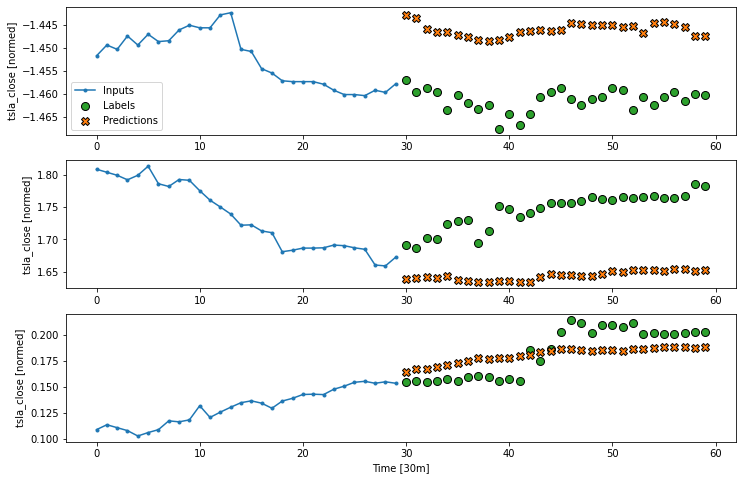

In [456]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
]) 

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence as a in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic [Generating Sequences With Recurrent Neural Networks](https://arxiv.org/abs/1308.0850).

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of single single-step multi-output models trained in the first half of this tutorial and run  in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)


#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single timestep.

The model will have the same basic form as the single-step `LSTM` models: An `LSTM` followed by a `layers.Dense` that converts the `LSTM` outputs to model predictions.

A `layers.LSTM` is a `layers.LSTMCell` wrapped in the higher level `layers.RNN` that manages the state and sequence results for you (See [Keras RNNs](https://www.tensorflow.org/guide/keras/rnn) for details).

In this case the model has to manually manage the inputs for each step so it uses `layers.LSTMCell` directly for the lower level, single time step interface.

In [457]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [458]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [459]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction, and the internal state of the LSTM:

In [460]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 12])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach to collecting the output predictions is to use a python list, and `tf.stack` after the loop.

Note: Stacking a python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length you would need to use a `tf.TensorArray` instead of a python list, and `tf.range` instead of the python `range`.

In [461]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [462]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 30, 12)


Now train the model:

430/430 [==============================] - 1s 3ms/step - loss: 0.7210 - mean_absolute_error: 0.3117


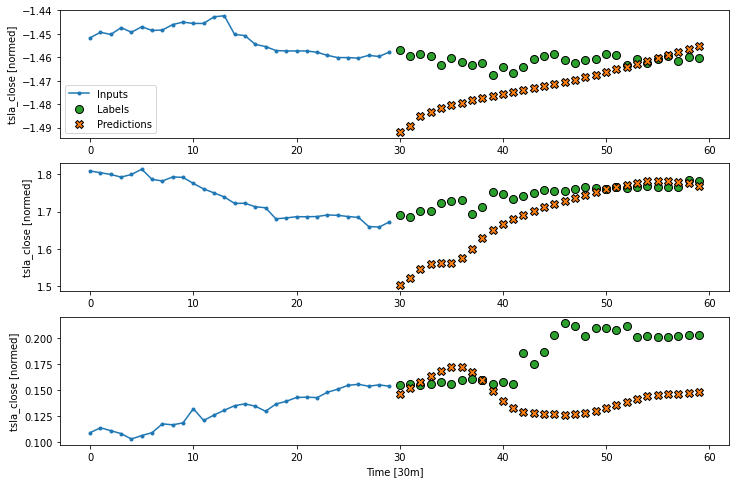

In [463]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

#### Custom LSTM


430/430 [==============================] - 1s 2ms/step - loss: 0.9146 - mean_absolute_error: 0.4090


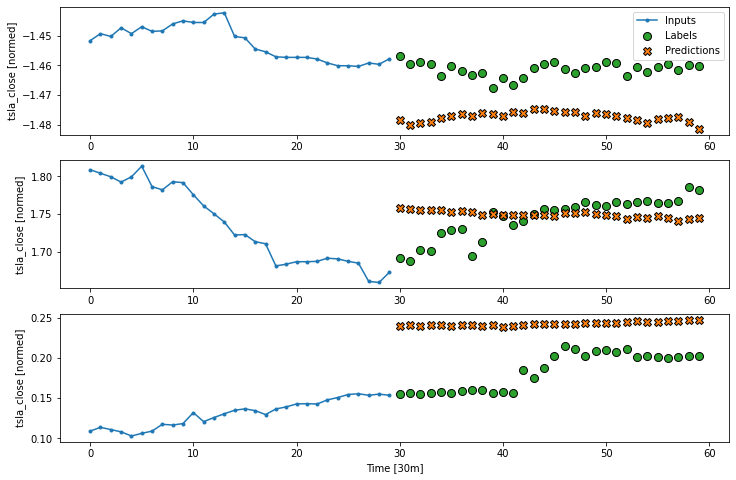

In [464]:
multi_custom_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Avg Pooling
    tf.keras.layers.AveragePooling1D(pool_size=2, strides=None, padding='same'),
    # Dropout
    tf.keras.layers.Dropout(.2),
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, dropout=.6)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, dropout=.6)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False, dropout=.6)),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_custom_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Custom LSTM'] = multi_custom_lstm_model.evaluate(multi_window.val)
multi_performance['Custom LSTM'] = multi_custom_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_custom_lstm_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem.

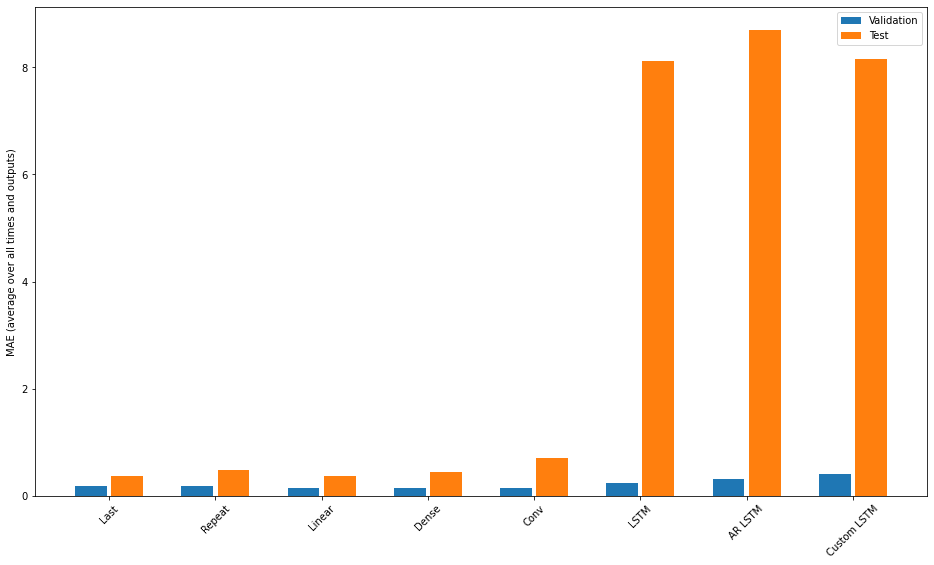

In [465]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = multi_custom_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances similar but also averaged across output timesteps. 

In [466]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.3698
Repeat  : 0.4883
Linear  : 0.3790
Dense   : 0.4456
Conv    : 0.7181
LSTM    : 8.1139
AR LSTM : 8.6937
Custom LSTM: 8.1629


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

* For further understanding, see:
  * Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition 
  * Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).
  * Lesson 8 of [Udacity's intro to TensorFlow for deep learning](https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187), and the [exercise notebooks](https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning) 
* Also remember that you can implement any [classical time series model](https://otexts.com/fpp2/index.html) in TensorFlow, this tutorial just focuses on TensorFlow's built-in functionality.